In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install d2l==0.17.6

In [ ]:
import os
path = '/content/drive/MyDrive'
os.chdir(path)

!source venv_d2l/bin/activate

path = '/content/drive/MyDrive/d2l-zh'
os.chdir(path)

In [ ]:
# 权重衰减 Weight Decay
# 最常见的处理过拟合的一种方法
# 怎么控制模型的容量呢？一是把模型变得比较小，参数比较少；二是使参数的值的选择范围变得比较小，权重衰退就是通过控制这个值的选择范围来进行的
# w每一项的平方和是小于一个特定的值theta，通常不会限制便宜b，实际上限制不限制b不会有太大影响
# 小的theta意味着更强的正则项，限制比较强
# 我们一般不会做硬性限制，而是使用均方范数作为柔性限制，对每个theta，都可以找到lambda使得之前的目标函数等价于 min l(w, b) + lambda/2*||w||^2
# 这一项是penalty，使得w不要特别大。lambda是超参数，控制了正则项的重要程度，等于0没有作用，整个这一项等于0；lambda趋向无穷，等价于theta趋向于0，使得最优解w*慢慢变成0
# 假设我们想要模型复杂度控制得比较低，那么可以慢慢增加lambda来满足我们的需求
# 更平滑，不是所有的值都需要小于thetha

# 为什么叫做权重衰退呢？
# 参数更新法制
# 计算梯度，先是对l项算梯度，再对penalty算梯度 a_l(w, b)/a_w + lambda * w
# 时间t更新参数 w_t+1 = w_t - eta * 梯度, 那么 w_t+1 = (1 - eta * lambda)*w_t - eta * a_l(w_t, b_t)/a_w_t， eta是学习率
# 跟之前不易的地方就是多了 - eta * lambda 这个项，如果没有加入二次罚项的话，这里通常是没有的
# 通常 eta * lambda < 1, 所以我们每次更新的时候都先把w_t乘以了一个小于1的正常数，所以每次是先把w的值变小一点点，再沿着梯度的反方向再走一点点，
# 所以呢为什么叫做权重衰退？因为每次更新的时候，因为lambda的缘故，每次更新前先把w权重做了一次放小，这是一次衰退

# 权重衰退通过L2正则项使得模型参数不会过大，从而控制模型复杂度
# 正则项权重是控制模型复杂度的超参数

# 权重衰减是最广泛使用的正则化的技术之一

%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
# 生成人工数据集 我们这里就是一个线性回归
# 偏差0.05，权重0.01是w，xi是我们随机的输入，在加上噪音
# 这里特地把训练数据造的比较小，训练数据越小越特别容易过拟合
# 数据越简单，模型越复杂的时候，越容易过拟合
# num_inputs就是特征维度，这里取值比较大是200
# 真实的w和b，w是全0.01的向量

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [ ]:
# 初始化模型参数
def init_params():
  w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
  b = torch.zeros(1, requires_grad=True)
  return [w, b]

In [ ]:
# 定义L2范数惩罚 -- 这一节的核心
# lambda我们会写到外面
def l2_penalty(w):
  return torch.sum(w.pow(2)) / 2

In [ ]:
# 训练函数和之前没本质区别，只是接受一个超参数lambda
# 定义很简单的线性回归和平方损失函数
# 因为样本比较小就20个样本，所以训练长一点，迭代100次

# 很标准的训练
# outer for loop 对每一次数据迭代
# inner for loop 对每一次从迭代器里拿出一个X和y
# 唯一不同的是算损失的时候要加上一个lambd * l2 penalty
def train(lambd):
  w, b = init_params()
  net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
  num_epochs, lr = 100, 0.003
  animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                          xlim=[5, num_epochs], legend=['train', 'test'])
  for epoch in range(num_epochs):
    for X, y in train_iter:
      # 增加了L2范数惩罚项，
      # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
      l = loss(net(X), y) + lambd * l2_penalty(w)
      l.sum().backward()
      d2l.sgd([w, b], lr, batch_size) # 优化参数
    if (epoch + 1) % 5 == 0:
      animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                               d2l.evaluate_loss(net, test_iter, loss)))
  print('w的L2范数是: ', torch.norm(w).item()) # L2范数是向量元素的平方和的平方根

w的L2范数是:  13.294967651367188


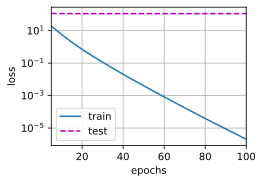

In [ ]:
# 忽略正则化直接训练
# 训练的损失一直在往下降，但是测试的损失基本上是平的，两者之间有个非常大的差别，是非常明显的过拟合
train(lambd=0)

w的L2范数是:  0.36512497067451477


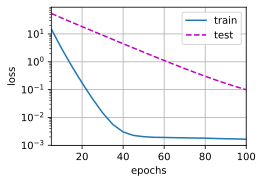

In [ ]:
# 使用权重衰减
# 虽然还是有过拟合，但是随着训练损失往下降，测试损失还是往下降的
# 超过50次训练就不会再往下走了，测试虽然还在下降，但是可能还是会有过拟合

# 还可以把lambd调到更大一点，现在的范数还是偏大

# 如果lambd过大，基本上就是欠拟合了，基本上不会动

train(lambd=3)

In [ ]:
# 简洁实现

def train_concise(wd):
  net = nn.Sequential(nn.Linear(num_inputs, 1))
  for param in net.parameters():
    param.data.normal_()
  loss = nn.MSELoss(reduction='none')
  num_epochs, lr = 100, 0.003
  # 偏置参数没有衰减
  # 这里是唯一区别，我们的罚既可以写在我们的目标函数里面，也可以写在我们的训练算法里面，说白了就是每次给当前的w乘上一个小的值就行了
  # 这样写还方便一点，自动求导的时候还少算一点，对于绝大多数框架来讲，基本上所有优化算法都提供一个weight_decay的选项
  trainer = torch.optim.SGD([
            {"params":net[0].weight, 'weight_decay': wd},
            {"params":net[0].bias}], lr=lr)
  animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                          xlim=[5, num_epochs], legend=['train', 'test'])
  for epoch in range(num_epochs):
    for X, y in train_iter:
      trainer.zero_grad()
      l = loss(net(X), y)
      l.mean().backward()
      trainer.step()
    if (epoch + 1) % 5 == 0:
      animator.add(epoch + 1,
                   (d2l.evaluate_loss(net, train_iter, loss),
                   d2l.evaluate_loss(net, test_iter, loss)))
  print('w的L2范数: ', net[0].weight.norm().item())

w的L2范数:  14.489654541015625


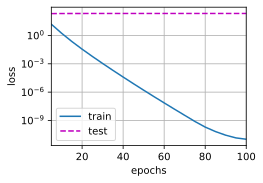

In [ ]:
# 这些图看起来和我们从零开始实现权重衰减时的图相同
train_concise(0)

w的L2范数:  0.41247257590293884


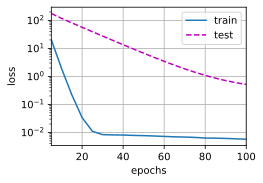

In [ ]:
train_concise(3)

限制w的取值范围，就不会学出一个非常不平滑的模型，让weight不放太大，也就是说只让在一些平滑的曲线里去选，这就意味着模型复杂度会变低。

实际问题中，权重衰减的值一般时取e-2，e-3，e-4。e-3比较普遍。权重衰退的效果有一点点，但是你不要太指望。之后会有更多的手段来做模型复杂度的控制。模型如果很复杂，权重衰退不会有特别好的效果。特别时对于MLP来讲，dropout可能效果还好一点。

w的最优解是学不到的，因为有噪音，学到的值会更大，所以需要lambda来往回拉。





In [ ]:
# 暂退法 Dropout 丢弃法
# 可能比权重衰退的效果更好
# 一个好的模型需要对输入数据的扰动鲁棒 使用有噪音的数据等价于Tikhonov正则
# 丢弃法：在层之间加入噪音，丢弃法其实是一个正则，p概率变成0，整体期望不变
# 通常将丢弃法作用在隐藏全连接层的输出上

# 正则项只在训练中使用，他们影响模型参数的更新
# 他们只对权重产生影响，当参数已经确定，是不需要正则的
# 在推理过程中，丢弃法之间返回输入 h = dropout(h) 这样也能保证确定性的输出

# 丢弃法将一些隐藏层的输出项随机置为0来控制模型复杂度
# 常作用在多层感知机的隐藏层输出上，很少用在CNN
# 丢弃概率是控制模型复杂度的超参数


# 我们实现drop_layer函数，该函数以dropout的概率丢弃张量输入X中的元素
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X, dropout):
  # assert语句用于断言某个条件是真的 dropout概率必须在0到1之间
  assert 0 <= dropout <= 1
  # dropout等于1返回全零
  if dropout == 1:
    return torch.zeros_like(X)
  # dropout丢弃概率等于0 表示不用丢 直接返回X
  if dropout == 0:
    return X
  # 0-1之间的均匀随机分布和丢弃概率比较 大于的话是1 否则是0
  mask = (torch.rand(X.shape) > dropout).float()
  return mask * X / (1.0 - dropout)

# 这里不是通常的numpy的写法，在X中随机选一些设成0，例如X[mask]=0, 不这么写是因为对GPU和CPU都不是很好
# 做乘法远远比选一个元素来得快，这样之后用gpu的话，算起来比较快

In [ ]:
# 测试drop_layer函数

# 精髓是每一次置为0的数不一样，如果是固定位置置为0，那就等价于把隐藏层大小变小了，一定要随机才有效果

X = torch.arange(16, dtype=torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 18., 20., 22., 24.,  0., 28., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [ ]:
# 定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [ ]:
dropout1, dropout2 = 0.2, 0.5

# 这里唯一的区别是是否is_training
# 两个隐藏层，三个线性层
class Net(nn.Module):
  def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
    super(Net, self).__init__()
    self.num_inputs = num_inputs
    self.training = is_training
    self.lin1 = nn.Linear(num_inputs, num_hiddens1)
    self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
    self.lin3 = nn.Linear(num_hiddens2, num_outputs)
    self.relu = nn.ReLU()

  def forward(self, X):
    # 第一个隐藏层的输出
    H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
    # 只有在训练模型时才使用dropout
    if self.training == True:
      # 在第一个全连接层之后添加一个dropout层
      H1 = dropout_layer(H1, dropout1)
    H2 = self.relu(self.lin2(H1))
    if self.training == True:
      # 在第二个全连接层之后添加一个dropout层
      H2 = dropout_layer(H2, dropout2)
    # 输出层是不做dropout的
    out = self.lin3(H2)
    return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

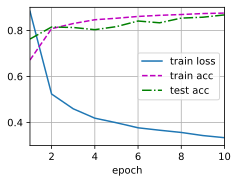

In [ ]:
# 训练和测试
# 这里我们用的256的隐藏层，对于我们的数据来说模型已经很大了，虽然结果差不多，但是dropout其实已经起了很大作用

# 假设不用dropout，概率都设为0，那么结果怎么样
# dropout是最主流的对多层感知机的控制
# 可以把模型设大一点，隐藏层大一点，然后用正则控制，效果可能更好，使用dropout等手段

num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [ ]:
# 简洁实现

net = nn.Sequential(# 先把输入拉平，拉成二维
                    nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    # 区别就是在这儿，在第一个全连接层之后添加一个dropout层
                    nn.Dropout(dropout1),
                    nn.Linear(256, 256),
                    nn.ReLU(),
                    # 在第二个全连接层之后添加一个dropout层
                    nn.Dropout(dropout2),
                    nn.Linear(256, 10))

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

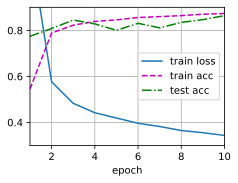

In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

如果被随机置0，那么梯度也会变成0. 但是没有置0的地方，你会乘以一个数，梯度也会相应的乘以一个数。dropout对求梯度是一个对称的函数。dropout的那一些输出他对应的权重，这一轮就不会被更新。

机器学习没有正确性，只有效果/精度好不好。

计算机里N个数相加，加的顺序不一样结果不一样。因为你的精度不够，cudnn造成的，结果随机性挺大的，几乎不能重复。但是使用cudnn可以加速50%-80%。不过基本上不需要可重复性，因为只要训练100次后精度足够就行。

随机性其实不是个坏事情，让结果更稳定。随机性一高，稳定性也会增加。随机还能收敛，下次也行。

丢弃法是每一层在调用前项运算的时候，随机丢一次。三个隐藏层，丢三次。

BN（batch norm）是给卷积层用的，dropout是给全连接层用的，不一样，没有什么相关性。

dropout是一个正则项，正则项唯一的作用是在更新权重的时候，让模型复杂度变低一点。在做推理的时候不会更新模型，所以不需要用dropout。

改标签是其他的正则化算法。什么都可以dropout。

Weight decay都在用，对卷积层、transformer都可以用。dropout只对全连接层用。dropout可能效果更好是因为更好调参，lambda不太好调。

dropout就三个值，0.1，0.5，0.9. 假设训练单隐藏层的全连接MLP，隐藏层大小64，train一下感觉还行，不用dropout。接下来就可以变成128，开dropout=0.5，感觉上等效，很有可能比直接64效果要好。可以过模拟，使得模型够强，通过正则让模型不要学偏。

dropout有可能会造收敛变慢，但是不用调整lr。因为lr是和期望与方差相关的。

Transformer可以看作是一个kernel machine，是一个核方法，而不是MLP。
